In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

from py_files.clip import build_clip

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


In [2]:
model_version = 'v1'

image_dir = "./resized_train"
clip_yaml = f"../Models/{model_version}.yaml"
caption_pred_file = "caption_prediction_train.csv"

In [4]:
clip_image_encoder, clip_text_encoder, clip = build_clip(clip_yaml)

Models downloaded.
Building clip...
Loading parameters...
Done.


In [8]:
def embed(elements, encoder, normalize=True):

    embeddings = encoder.predict(elements)

    if normalize:
        embeddings = tf.math.l2_normalize(embeddings, axis=1)

    return embeddings

In [9]:
def zeroshot_classifier(images, classes, text_encoder, image_encoder, normalize=True):

    embedded_classes = embed(classes, text_encoder, normalize)
    embedded_images = embed(images, image_encoder, normalize)

    similarities = tf.matmul(embedded_images, embedded_classes, transpose_b=True)

    return tf.nn.softmax(similarities, axis=1)

In [12]:
captions_df = pd.read_csv(caption_pred_file, sep='\t')
max_len = captions_df.caption.str.len().max()
pd.set_option('display.max_colwidth', 50)

image_size = (128, 128, 3)

# Get the filenames of the images
image_filenames = sorted(os.listdir(image_dir))[15:30]
num_images = len(image_filenames)

# Pre-allocate the whole numpy array to store images
images = []

captions = []

# Iterate over the dataframe and match the images with captions
for i, image_filename in enumerate(tqdm(image_filenames)):
    
    # Extract the image ID from the filename
    image_id = image_filename.split('.')[0]

    # Load image
    image_path = image_dir + '/' + image_filename
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_size[0], image_size[1]))
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image /= 255.0

    # Insert image in array
    images.append(image)

    # Find corresponding caption
    caption = captions_df[captions_df['ID'] == image_id]['caption'].to_string(index=False)
    captions.append(caption)

100%|██████████| 15/15 [00:00<00:00, 246.98it/s]


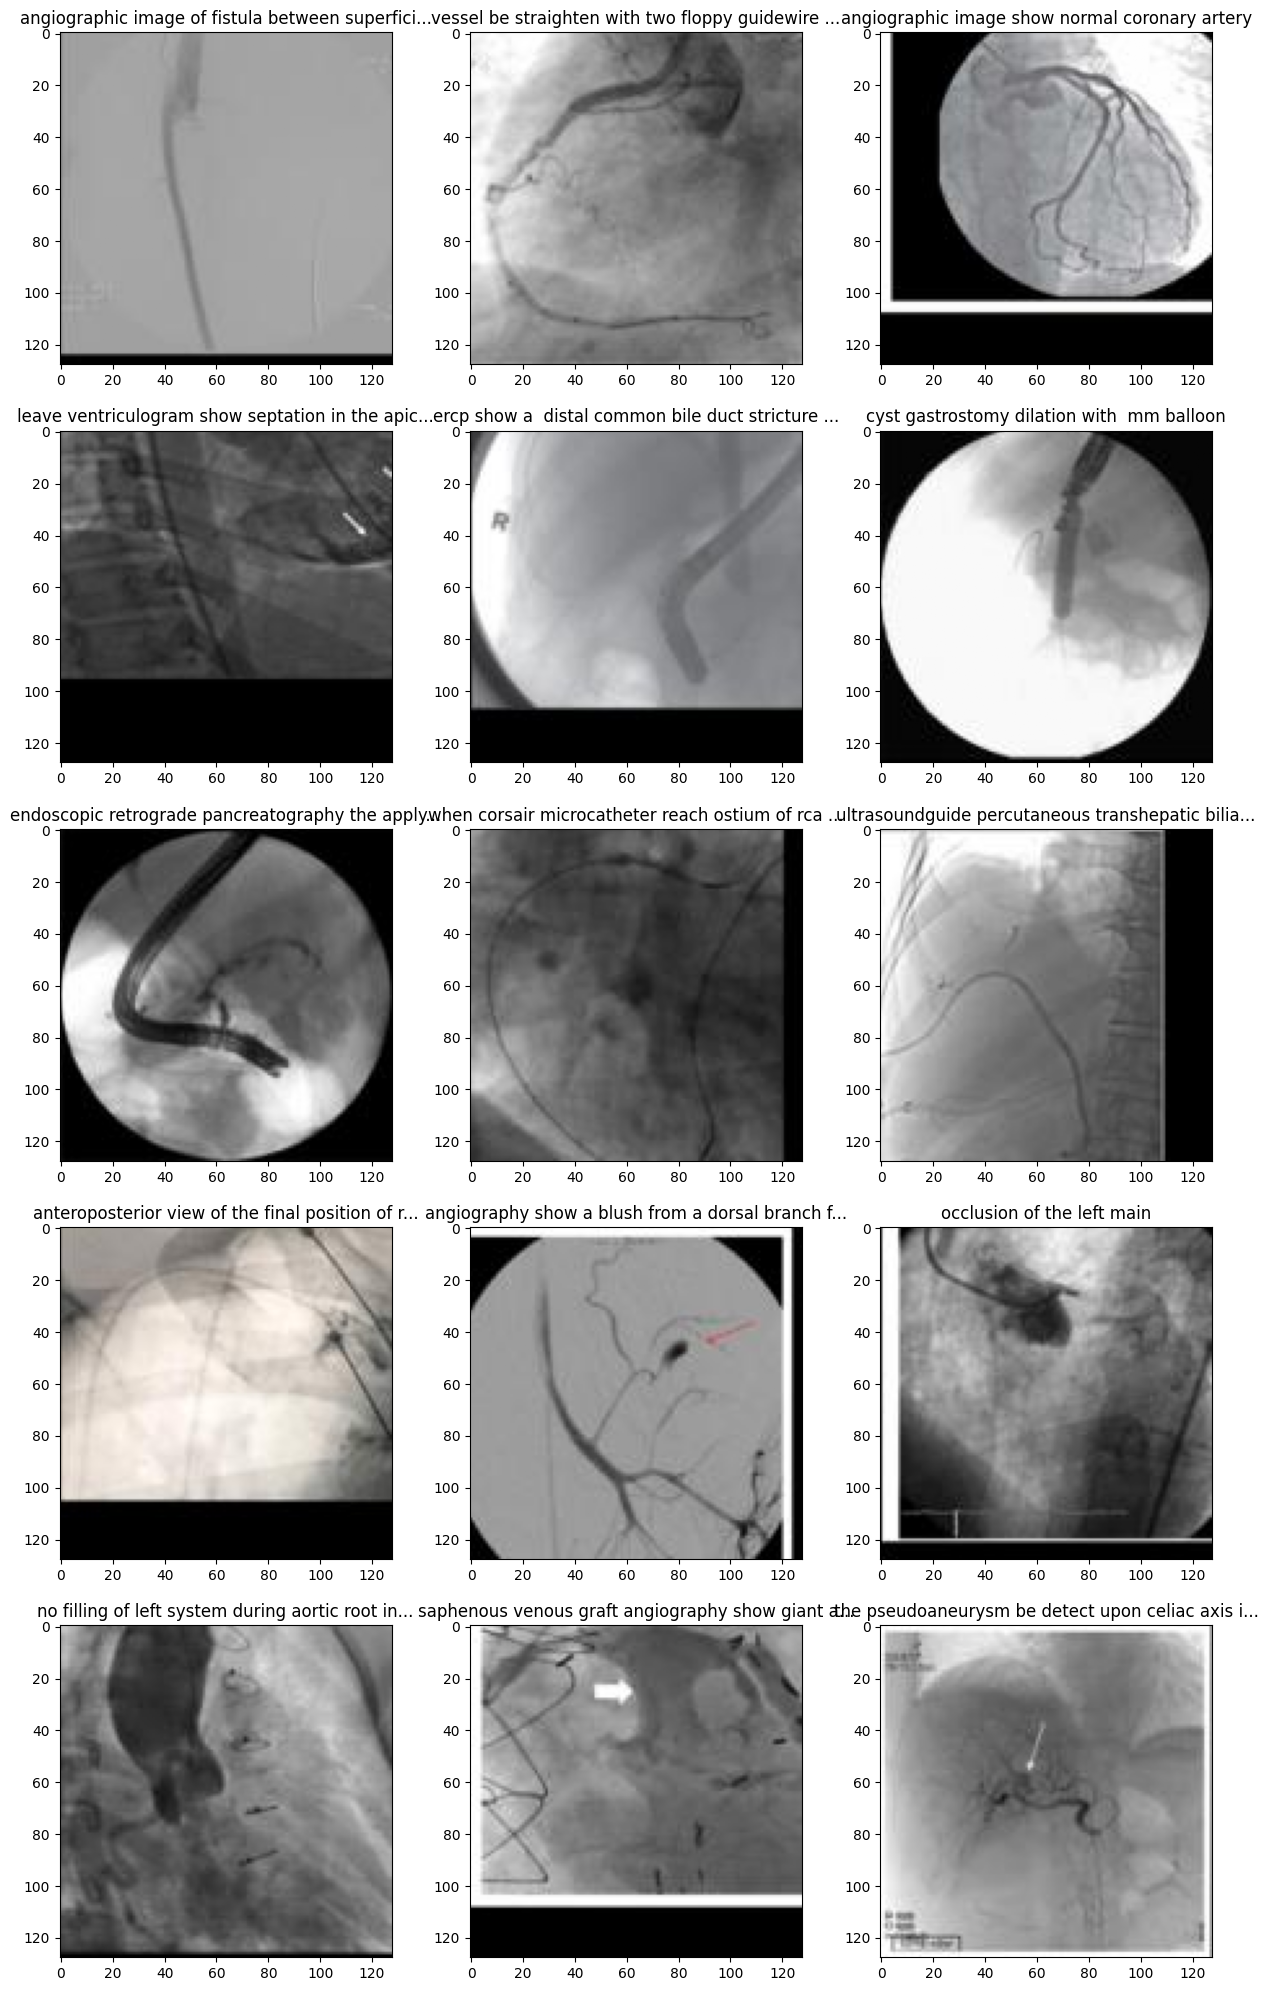

In [13]:
fig, axs = plt.subplots(5, 3, figsize=(15,25))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.title.set_text(captions[i])

In [14]:
# The selected image should be a ventriculogram
image_to_classify = tf.reshape(images[3], (1,128,128,3))
classes = ['angiography', 'venogram', 'stentgraph', 'ventriculogram']

In [15]:
res = zeroshot_classifier(image_to_classify, classes, clip_text_encoder, clip_image_encoder)

1/1 [==============================] - 2s 2s/step


In [16]:
idx = np.argmax(res)
confidence = np.max(res)
print(f'This is a photo of a {classes[idx]}, {confidence*100:.3f}%')

This is a photo of a ventriculogram, 27.587%
